In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange

np.random.seed(42)

In [18]:
def generate(size=5000, a=-1, b=1, treshold=1/4):
    coords = np.random.rand(size, 2)
    coords = coords * abs(b - a) + a
    marks = np.array(list(map(lambda x: int(x[0] ** 2 + x[1] ** 2 > treshold), coords)))
    if np.unique(marks).size == 1:
        return generate(size, a, b, treshold)
    df = pd.DataFrame(coords, columns=['x', 'y'])
    df['mark'] = marks
    return df

In [19]:
df = generate()

In [20]:
df.head()

,x,y,mark
0,-0.250920,0.901429,1
1,0.463988,0.197317,1
2,-0.687963,-0.688011,1
3,-0.883833,0.732352,1
4,0.202230,0.416145,0


<AxesSubplot:xlabel='x', ylabel='y'>

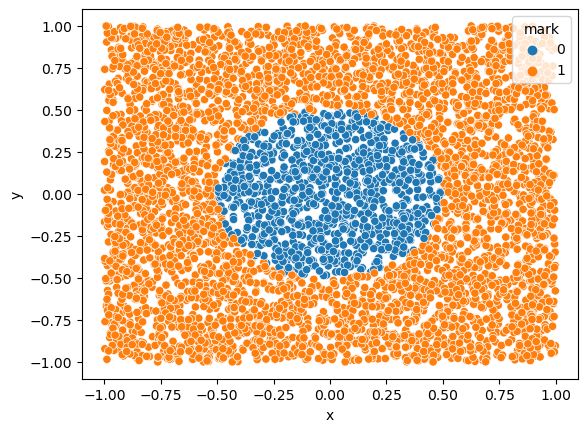

In [21]:
sns.scatterplot(data=df, x='x', y='y', hue='mark')

In [22]:
class Metrics:
    @staticmethod
    def get_metrcis_names():
        return ['accuracy', 'precision', 'recall', 'f1']
        
    @staticmethod
    def get_metrics(y_true, y_pred):
        return {
            'accuracy': Metrics.accuracy(y_true, y_pred),
            'precision': Metrics.precision(y_true, y_pred),
            'recall': Metrics.recall(y_true, y_pred),
            'f1': Metrics.f1(y_true, y_pred)
        }
    
    @staticmethod
    def accuracy(y_true, y_pred):
        return np.mean(y_true == y_pred)

    @staticmethod
    def precision(y_true, y_pred):
        tp = np.sum(y_true * y_pred)
        fp = np.sum((1 - y_true) * y_pred)
        return tp / (tp + fp)
    
    @staticmethod
    def recall(y_true, y_pred):
        tp = np.sum(y_true * y_pred)
        fn = np.sum(y_true * (1 - y_pred))
        return tp / (tp + fn)

    @staticmethod
    def f1(y_true, y_pred):
        p = Metrics.precision(y_true, y_pred)
        r = Metrics.recall(y_true, y_pred)
        return 2 * p * r / (p + r)

    @staticmethod
    def report(y_true, y_pred):
        print(f'accuracy:  {Metrics.accuracy(y_true, y_pred):.4f}')
        print(f'precision: {Metrics.precision(y_true, y_pred):.4f}')
        print(f'recall:    {Metrics.recall(y_true, y_pred):.4f}')
        print(f'f1:        {Metrics.f1(y_true, y_pred):.4f}')

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.svm import NuSVC
from sklearn.model_selection import GridSearchCV

In [24]:
X_train, X_test, y_train, y_test = train_test_split(df[['x', 'y']], df['mark'], test_size=0.2)

linear
accuracy:  0.4590
precision: 0.9043
recall:    0.3649
f1:        0.5200

poly
accuracy:  0.9930
precision: 1.0000
recall:    0.9913
f1:        0.9956

rbf
accuracy:  0.9680
precision: 0.9617
recall:    1.0000
f1:        0.9805

sigmoid
accuracy:  0.5980
precision: 0.7522
recall:    0.7447
f1:        0.7484



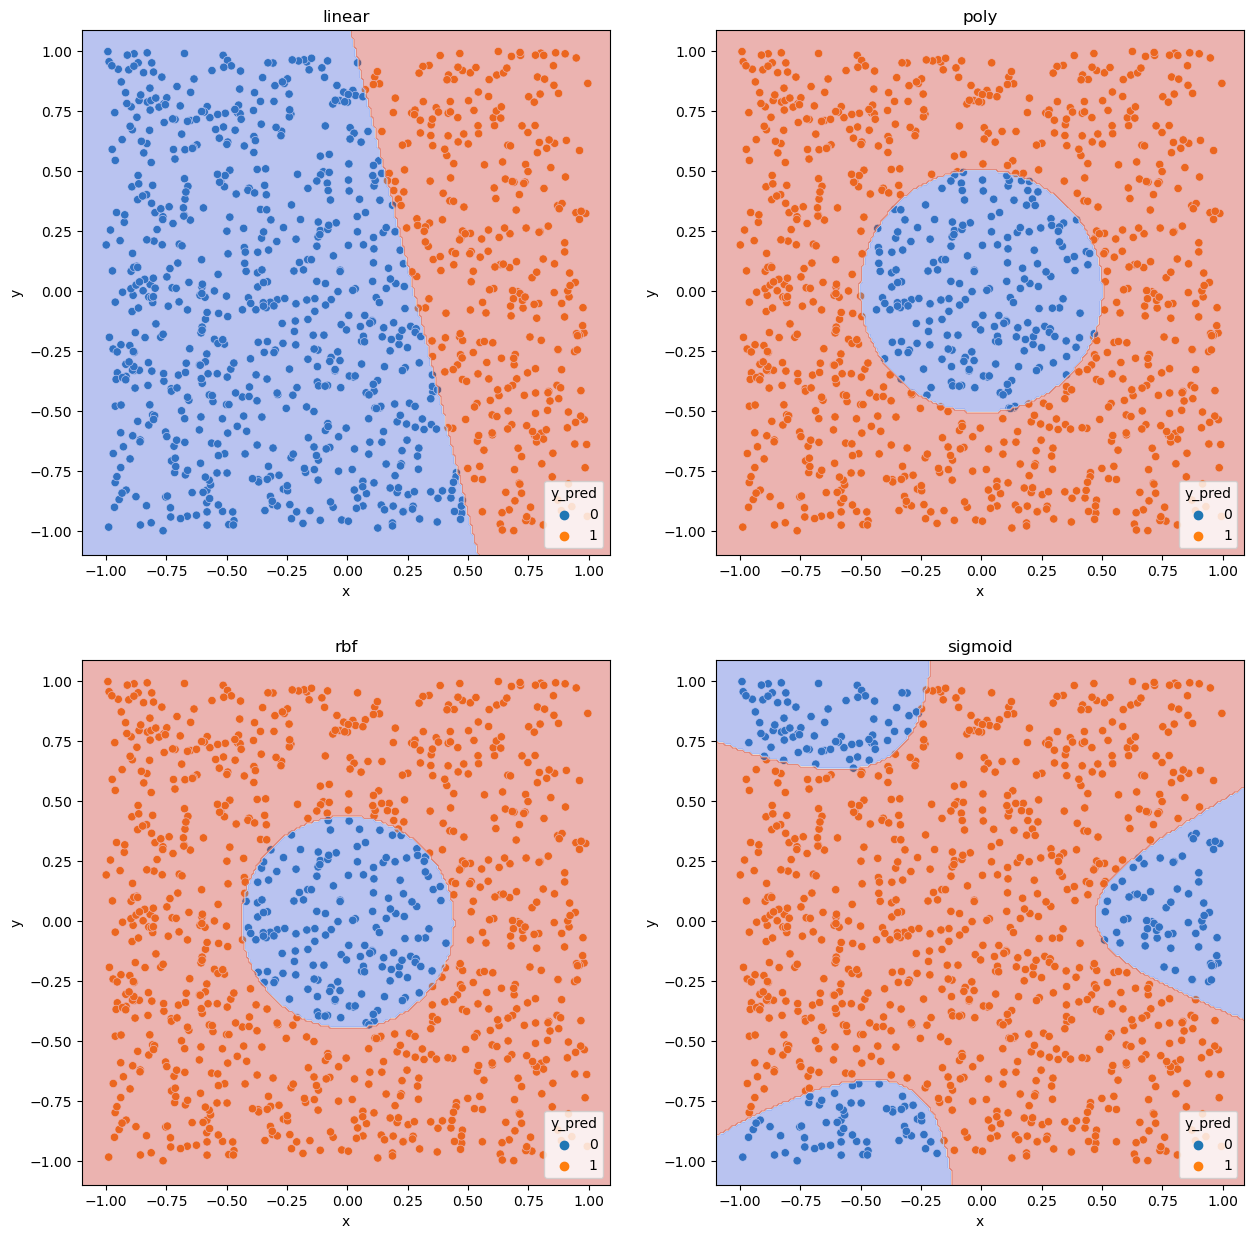

In [39]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(15, 15))
for i, kernel in enumerate(['linear', 'poly', 'rbf', 'sigmoid']):
    model = NuSVC(kernel=kernel, nu=0.4, degree=2)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(kernel)

    res_df = pd.DataFrame(X_test, columns=['x', 'y'])
    res_df['y_pred'] = y_pred

    sns.scatterplot(data=res_df, x='x', y='y', hue='y_pred', ax=axs[i // 2, i % 2])
    axs[i // 2, i % 2].set_title(kernel)
    x_min, x_max = X_train['x'].min() - 0.1, X_train['x'].max() + 0.1
    y_min, y_max = X_train['y'].min() - 0.1, X_train['y'].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    axs[i // 2, i % 2].contourf(xx, yy, Z, alpha=0.4, cmap='coolwarm')


    Metrics.report(y_test, y_pred)
    print()

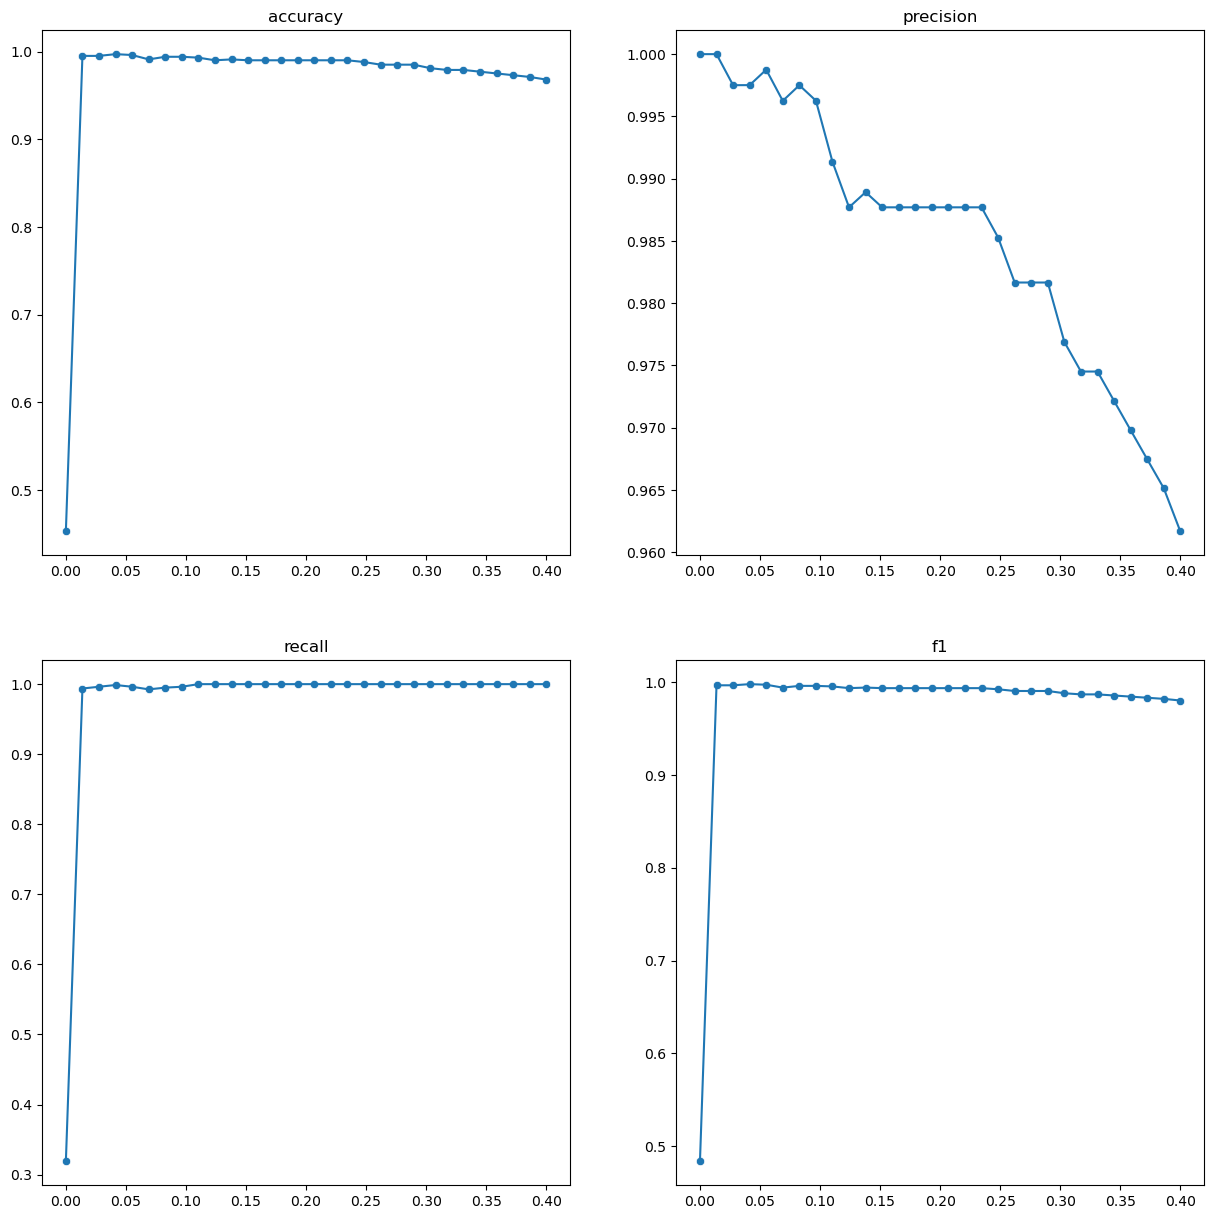

In [ ]:
nus = np.linspace(1e-10, 0.4, 30)
metrics = {}
for metric in Metrics.get_metrcis_names():
    metrics[metric] = []
    
for nu in nus:
    model = NuSVC(kernel='rbf', nu=nu)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    calc_metrics = Metrics.get_metrics(y_test, y_pred)
    for metric in calc_metrics.keys():
        metrics[metric].append(calc_metrics[metric])

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(15, 15))
for i, metric in enumerate(metrics.keys()):
    sns.lineplot(x=nus, y=metrics[metric], ax=axs[i // 2, i % 2])
    sns.scatterplot(x=nus, y=metrics[metric], ax=axs[i // 2, i % 2])
    axs[i // 2, i % 2].set_title(metric)

In [ ]:
def smooth_line(y, window=10):
    return np.convolve(y, np.ones(window) / window, mode='valid')

In [46]:
metrics = {}

import warnings
warnings.filterwarnings("ignore")

test = generate(50)
X_test, y_test = test[['x', 'y']], test['mark']
# nus = []

for metric in Metrics.get_metrcis_names():
    metrics[metric] = []
    
sizes = range(10, 10000, 10)
    
for size in tqdm(sizes):
    model = NuSVC(kernel='rbf')
    train = generate(size)

    # search = GridSearchCV(model, {'nu': np.linspace(1e-10, 0.4, 30)}, cv=5, scoring='f1', refit=True, n_jobs=-1, verbose=0).fit(train[['x', 'y']], train['mark'])
    # nus.append(search.best_params_['nu'])

    model = NuSVC(kernel='rbf', nu=0.1)

    X_train, y_train = train[['x', 'y']], train['mark']
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    calc_metrics = Metrics.get_metrics(y_test, y_pred)

    for metric in calc_metrics.keys():
        metrics[metric].append(calc_metrics[metric])

  0%|          | 0/999 [00:00<?, ?it/s]

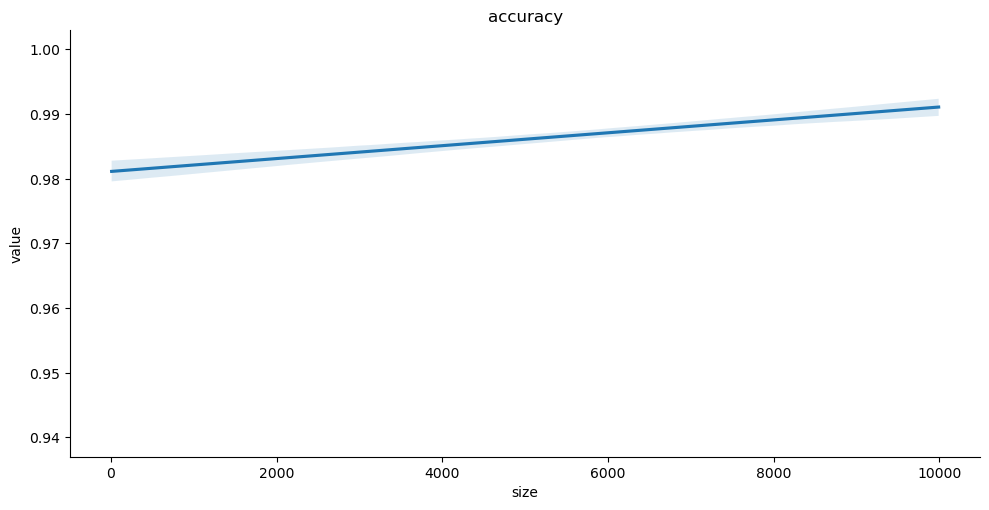

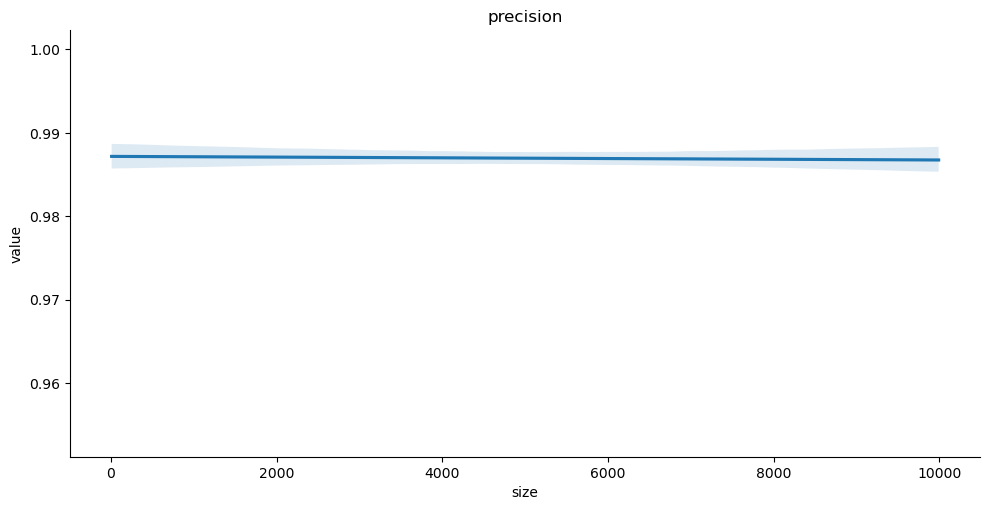

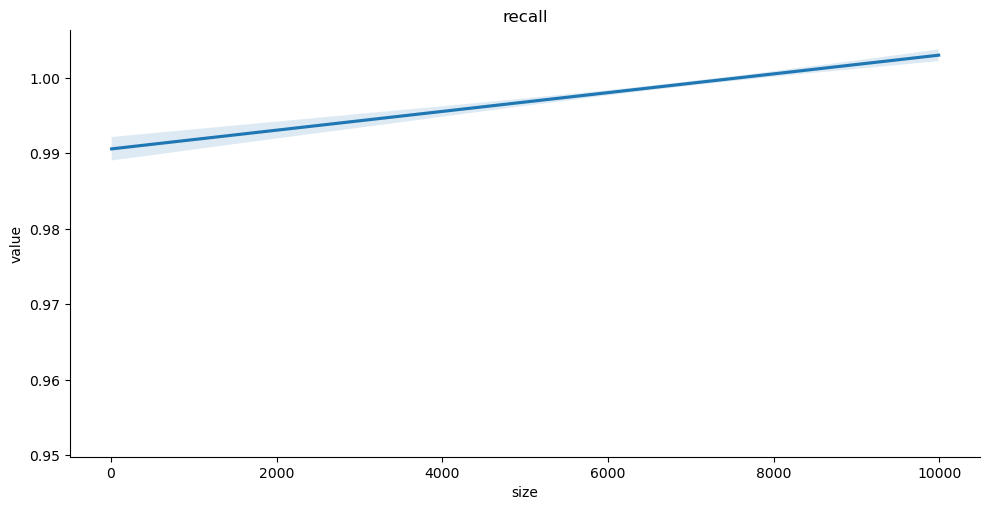

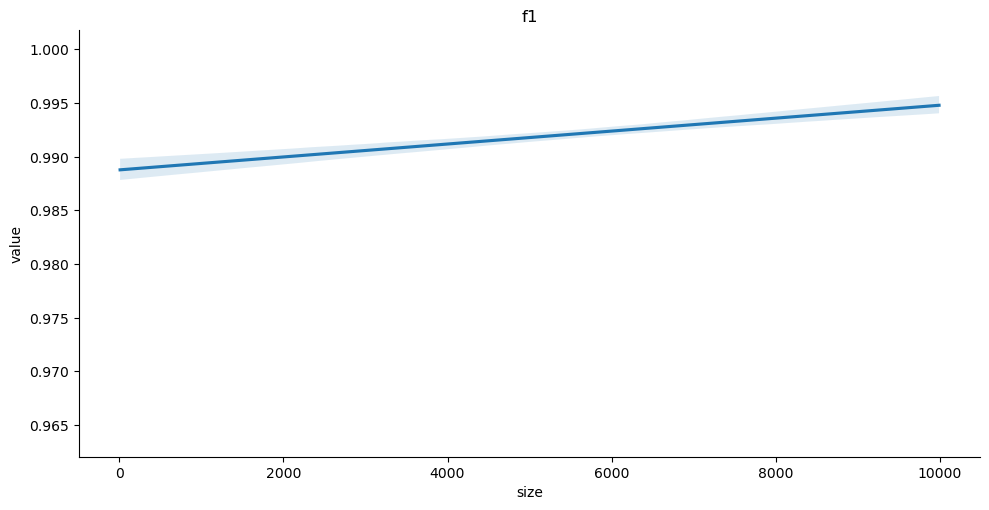

In [47]:
for i, metric in enumerate(metrics.keys()):
    data = pd.DataFrame({'size': sizes, 'value': metrics[metric]})
    sns.lmplot(data=data, x='size', y='value', height=5, aspect=2, markers='')
    plt.title(metric)

In [48]:
# sns.lineplot(x=sizes, y=nus)